In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import yaml
from dotenv import load_dotenv
import os
import warnings
warnings.filterwarnings('ignore')

# Load environment variables
load_dotenv()

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Load Data from Database

In [2]:
# Helper function to parse config values
def get_config_value(yaml_value, env_var, cast=str):
    env_val = os.getenv(env_var)
    if env_val is not None:
        return cast(env_val)
    if isinstance(yaml_value, str) and yaml_value.startswith("${") and ":" in yaml_value:
        return cast(yaml_value.split(":", 1)[1].rstrip("}"))
    return cast(yaml_value)

# Load database configuration
with open('../config/database.yaml', 'r') as f:
    db_cfg_raw = yaml.safe_load(f)['database']

db_cfg = {
    'host': get_config_value(db_cfg_raw['host'], 'DB_HOST'),
    'port': get_config_value(db_cfg_raw['port'], 'DB_PORT', int),
    'name': get_config_value(db_cfg_raw['name'], 'DB_NAME'),
    'user': get_config_value(db_cfg_raw['user'], 'DB_USER'),
    'password': get_config_value(db_cfg_raw['password'], 'DB_PASSWORD'),
}

# Connect to PostgreSQL database
engine = create_engine(
    f"postgresql+psycopg2://{db_cfg['user']}:{db_cfg['password']}@{db_cfg['host']}:{db_cfg['port']}/{db_cfg['name']}"
)

# Load all data from sensor_data table
df_raw = pd.read_sql("SELECT * FROM sensor_data ORDER BY timestamp;", engine)

print(f"Raw data loaded successfully!")
print(f"Shape: {df_raw.shape}")
print(f"Date range: {df_raw['timestamp'].min()} to {df_raw['timestamp'].max()}")

Raw data loaded successfully!
Shape: (8735, 10)
Date range: 2022-06-06 00:29:00+00:00 to 2022-12-04 23:29:00+00:00


In [3]:
# Display first few rows and basic info
df_raw.head()

,id,timestamp,unix_timestamp,temperature_surface,temperature_atmosphere,relative_humidity,cond_low_freq,cond_high_freq,corrosion_rate,created_at
0,1,2022-06-06 00:29:00+00:00,1654475340,21.63,21.23,47.64,0.005,5.429,0.005,2025-12-10 11:33:33.428277+00:00
1,2,2022-06-06 00:59:00+00:00,1654477140,21.53,21.16,47.78,0.005,5.000,0.005,2025-12-10 11:33:33.428277+00:00
2,3,2022-06-06 01:29:00+00:00,1654478940,21.44,21.06,48.00,0.005,5.000,0.005,2025-12-10 11:33:33.428277+00:00
3,4,2022-06-06 01:59:00+00:00,1654480740,21.36,20.98,48.15,0.005,5.286,0.005,2025-12-10 11:33:33.428277+00:00
4,5,2022-06-06 02:29:00+00:00,1654482540,21.29,20.88,48.34,0.005,5.000,0.005,2025-12-10 11:33:33.428277+00:00


## 2. Outlier Removal Using Z-Scores

Z-score measures how many standard deviations a data point is from the mean. Typically, data points with |Z-score| > 3 are considered outliers.

In [4]:
# Define columns to check for outliers (exclude ID, timestamp, and created_at)
numeric_cols = ['temperature_surface', 'temperature_atmosphere', 'relative_humidity', 
                'cond_low_freq', 'cond_high_freq', 'corrosion_rate']

# Create a copy for preprocessing
df = df_raw.copy()

print(f"Original data shape: {df.shape}")
print(f"\nData points per column before outlier removal:")
for col in numeric_cols:
    print(f"  {col}: {df[col].notna().sum()}")

Original data shape: (8735, 10)

Data points per column before outlier removal:
  temperature_surface: 8735
  temperature_atmosphere: 8735
  relative_humidity: 8735
  cond_low_freq: 8735
  cond_high_freq: 8735
  corrosion_rate: 8735


In [5]:
# Calculate Z-scores for each numeric column
z_scores = np.abs(stats.zscore(df[numeric_cols], nan_policy='omit'))

# Define threshold for outlier detection (typically 3)
z_threshold = 3

# Identify rows where ANY column has a Z-score > threshold
outlier_mask = (z_scores > z_threshold).any(axis=1)

print(f"Number of outlier rows detected: {outlier_mask.sum()}")
print(f"Percentage of outliers: {(outlier_mask.sum() / len(df)) * 100:.2f}%")

# Show outliers per column
print(f"\nOutliers per column (Z-score > {z_threshold}):")
for i, col in enumerate(numeric_cols):
    outliers_in_col = (z_scores[:, i] > z_threshold).sum()
    print(f"  {col}: {outliers_in_col}")

Number of outlier rows detected: 288
Percentage of outliers: 3.30%

Outliers per column (Z-score > 3):
  temperature_surface: 1
  temperature_atmosphere: 1
  relative_humidity: 0
  cond_low_freq: 0
  cond_high_freq: 151
  corrosion_rate: 172


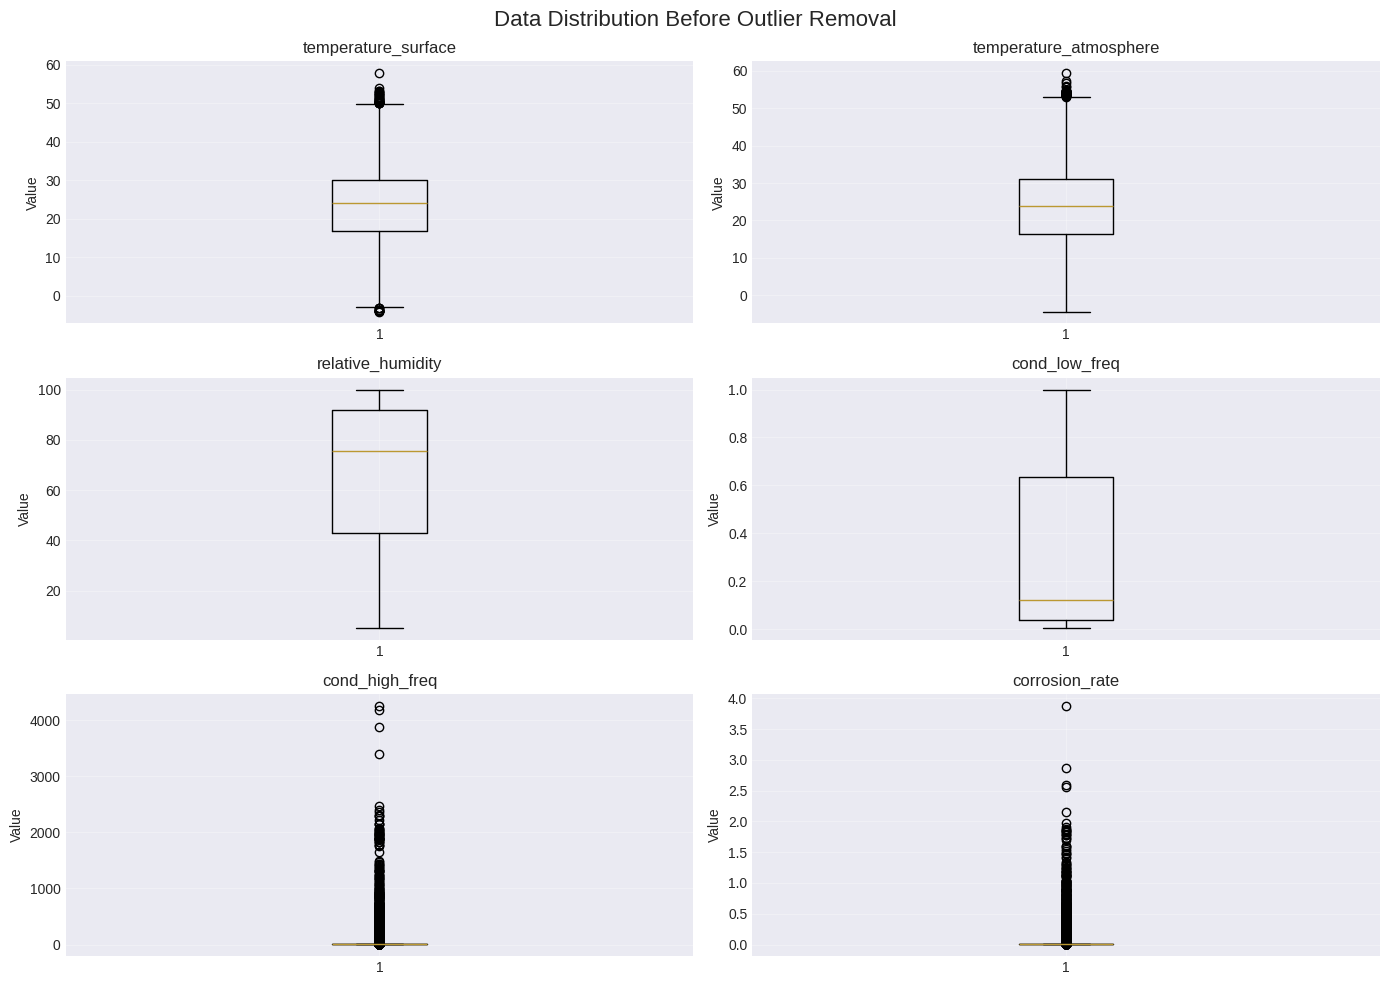

In [6]:
# Visualize outliers before removal
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('Data Distribution Before Outlier Removal', fontsize=16)

for idx, col in enumerate(numeric_cols):
    row = idx // 2
    col_idx = idx % 2
    
    axes[row, col_idx].boxplot(df[col].dropna())
    axes[row, col_idx].set_title(col)
    axes[row, col_idx].set_ylabel('Value')
    axes[row, col_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# Remove outliers
df_no_outliers = df[~outlier_mask].copy()

print(f"\nData shape after outlier removal: {df_no_outliers.shape}")
print(f"Rows removed: {len(df) - len(df_no_outliers)}")
print(f"Percentage of data retained: {(len(df_no_outliers) / len(df)) * 100:.2f}%")


Data shape after outlier removal: (8447, 10)
Rows removed: 288
Percentage of data retained: 96.70%


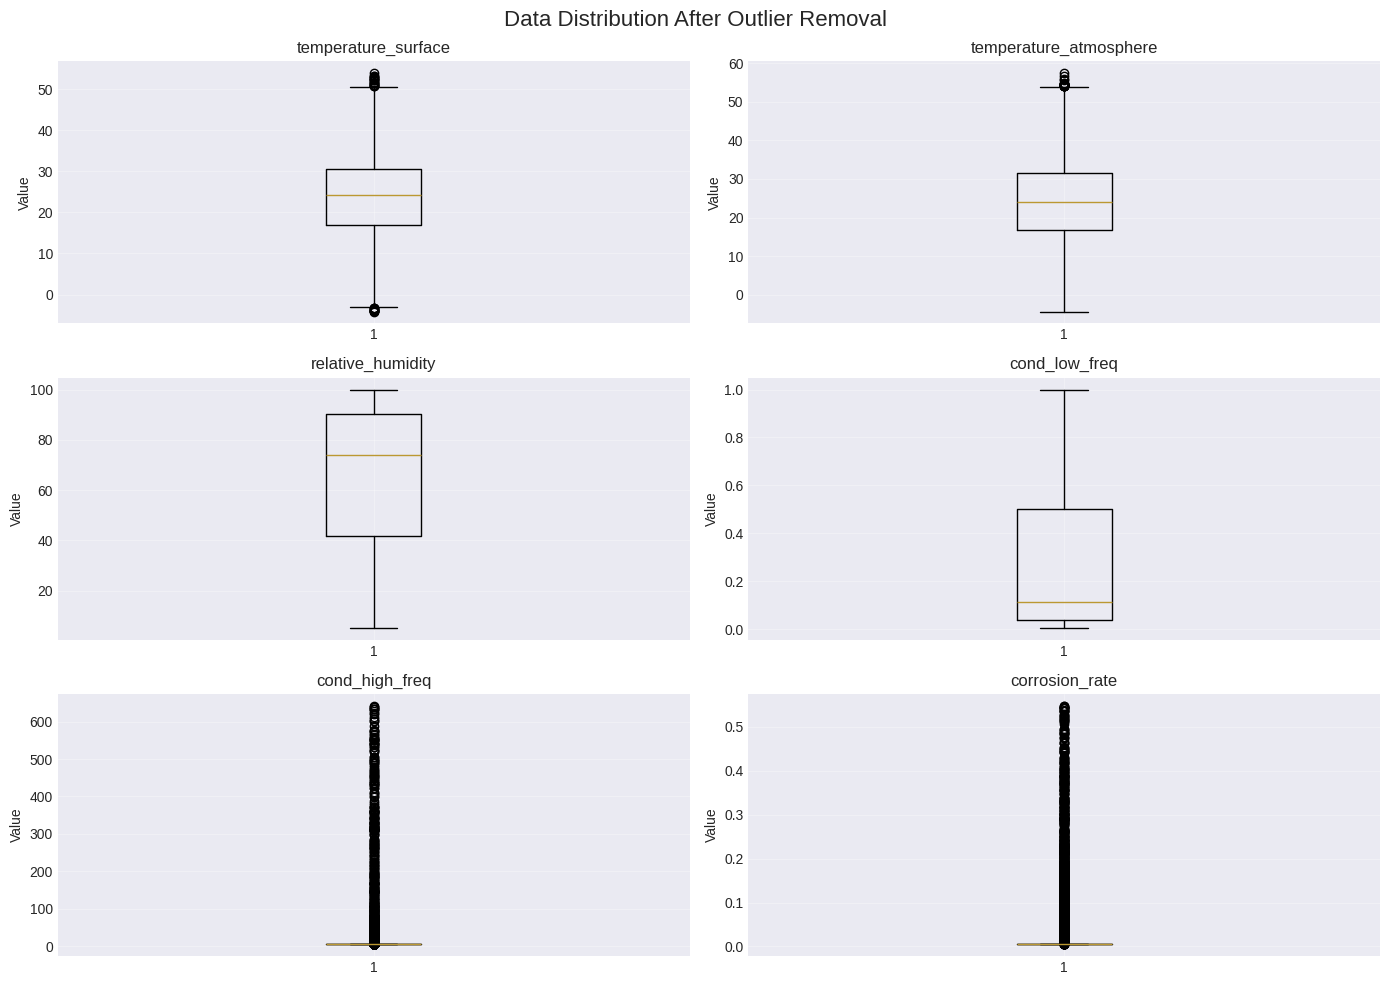

In [8]:
# Visualize data after outlier removal
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('Data Distribution After Outlier Removal', fontsize=16)

for idx, col in enumerate(numeric_cols):
    row = idx // 2
    col_idx = idx % 2
    
    axes[row, col_idx].boxplot(df_no_outliers[col].dropna())
    axes[row, col_idx].set_title(col)
    axes[row, col_idx].set_ylabel('Value')
    axes[row, col_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Daily Aggregation (Temporal Downsampling)

Since the time interval of captured data is much shorter than any changes, we aggregate data to daily averages.

In [9]:
# Convert timestamp to datetime if not already
df_no_outliers['timestamp'] = pd.to_datetime(df_no_outliers['timestamp'])

# Extract date (without time) for grouping
df_no_outliers['date'] = df_no_outliers['timestamp'].dt.date

# Check sampling frequency before aggregation
print(f"Total records before aggregation: {len(df_no_outliers)}")
print(f"Number of unique dates: {df_no_outliers['date'].nunique()}")
print(f"Average samples per day: {len(df_no_outliers) / df_no_outliers['date'].nunique():.1f}")

Total records before aggregation: 8447
Number of unique dates: 182
Average samples per day: 46.4


In [10]:
# Aggregate by day - calculate mean for each day
df_daily = df_no_outliers.groupby('date')[numeric_cols].mean().reset_index()

# Convert date back to datetime for consistency
df_daily['timestamp'] = pd.to_datetime(df_daily['date'])
df_daily = df_daily.drop('date', axis=1)

print(f"\nData shape after daily aggregation: {df_daily.shape}")
print(f"Number of daily samples: {len(df_daily)}")
print(f"Date range: {df_daily['timestamp'].min()} to {df_daily['timestamp'].max()}")


Data shape after daily aggregation: (182, 7)
Number of daily samples: 182
Date range: 2022-06-06 00:00:00 to 2022-12-04 00:00:00


In [11]:
# Display first few rows of daily aggregated data
df_daily.head(10)

,temperature_surface,temperature_atmosphere,relative_humidity,cond_low_freq,cond_high_freq,corrosion_rate,timestamp
0,23.009375,22.588542,54.756875,0.005000,5.071417,0.005000,2022-06-06
1,19.714375,19.358750,71.187500,0.346971,79.148792,0.042302,2022-06-07
2,20.976458,20.544583,69.181667,0.355935,86.825125,0.017862,2022-06-08
3,25.243333,24.877083,64.882083,0.437312,143.783062,0.023342,2022-06-09
4,25.134167,24.731458,64.666875,0.328577,5.206812,0.005000,2022-06-10
5,25.541458,25.040417,56.121250,0.134498,5.108625,0.005000,2022-06-11
6,25.548333,25.181458,59.728333,0.170138,5.180042,0.005000,2022-06-12
7,23.212973,22.928919,63.602432,0.265027,39.494351,0.040057,2022-06-13
8,17.208372,16.890000,97.733488,0.906463,27.243791,0.102326,2022-06-14
9,25.782917,25.537292,68.388750,0.013258,5.019333,0.005000,2022-06-15


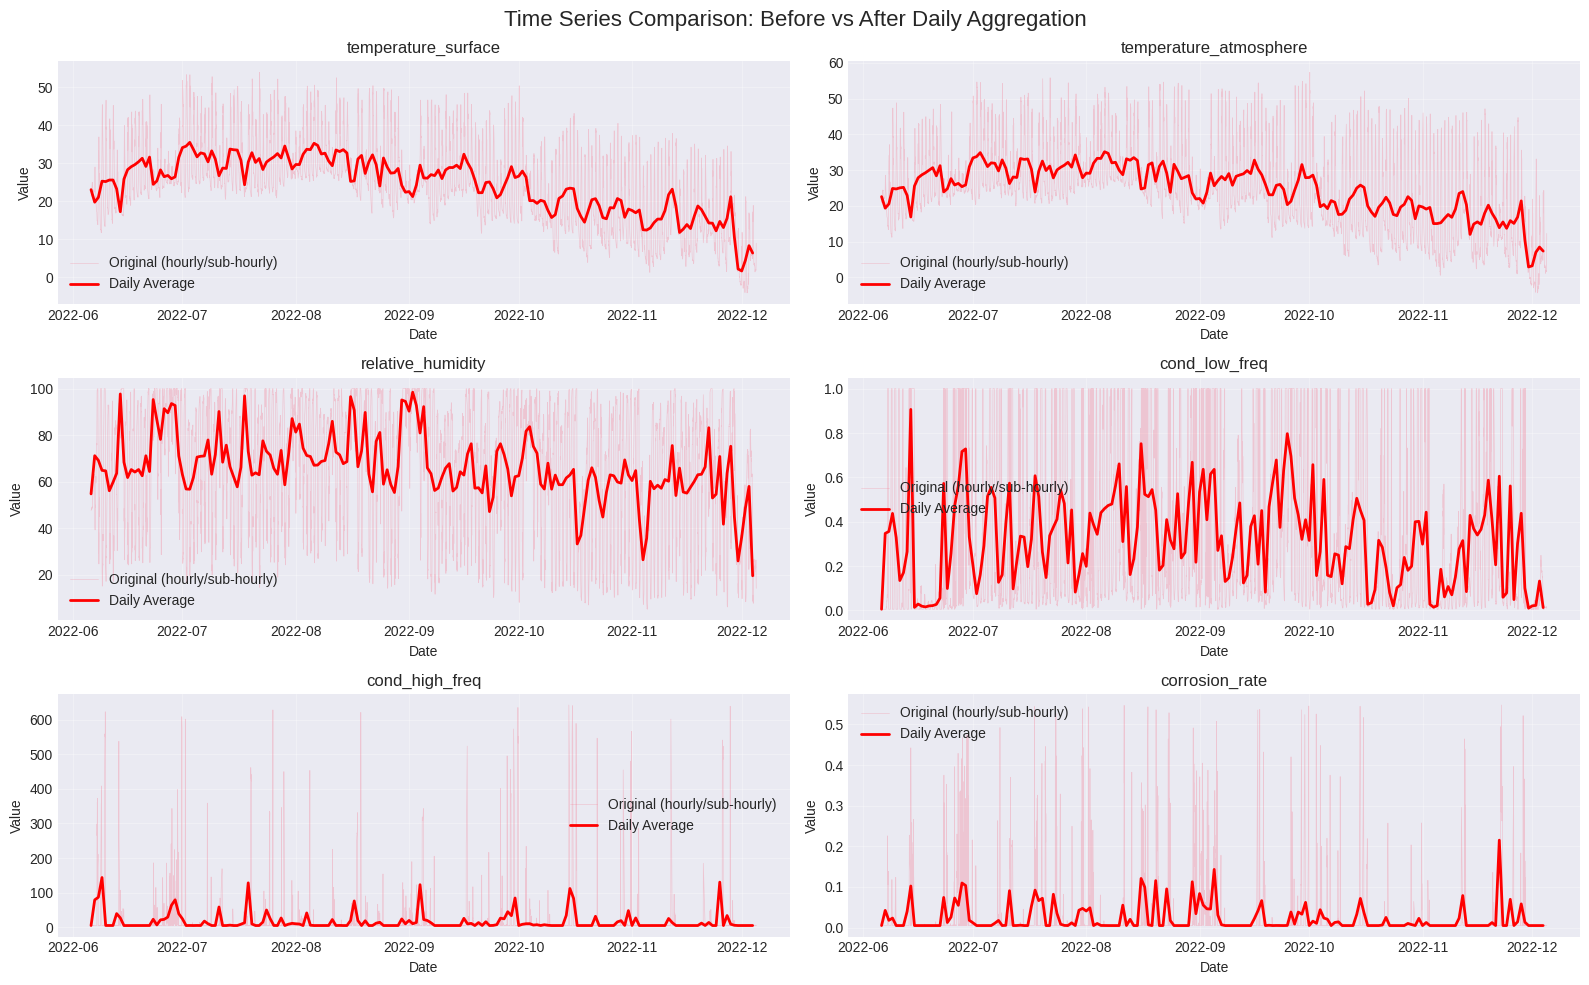

In [12]:
# Visualize the effect of daily aggregation
fig, axes = plt.subplots(3, 2, figsize=(16, 10))
fig.suptitle('Time Series Comparison: Before vs After Daily Aggregation', fontsize=16)

for idx, col in enumerate(numeric_cols):
    row = idx // 2
    col_idx = idx % 2
    
    # Plot original data (sample for visibility)
    axes[row, col_idx].plot(df_no_outliers['timestamp'], df_no_outliers[col], 
                            alpha=0.3, linewidth=0.5, label='Original (hourly/sub-hourly)')
    
    # Plot daily aggregated data
    axes[row, col_idx].plot(df_daily['timestamp'], df_daily[col], 
                            linewidth=2, label='Daily Average', color='red')
    
    axes[row, col_idx].set_title(col)
    axes[row, col_idx].set_xlabel('Date')
    axes[row, col_idx].set_ylabel('Value')
    axes[row, col_idx].legend()
    axes[row, col_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Normalization Using MinMaxScaler

**IMPORTANT**: Following the paper's methodology, normalize **ALL features** to [0, 1].  
This includes both input features AND the target variable (`corrosion_rate`), as required by the sigmoid activation function in the output layer.

In [13]:
# Define all numeric features to be normalized (inputs + target)
all_feature_cols = ['temperature_surface', 'temperature_atmosphere', 'relative_humidity', 
                    'cond_low_freq', 'cond_high_freq', 'corrosion_rate']

# Show data ranges before normalization
print("All features (will be normalized to [0, 1]):")
print(df_daily[all_feature_cols].describe())

All features (will be normalized to [0, 1]):
       temperature_surface  temperature_atmosphere  relative_humidity  \
count           182.000000              182.000000         182.000000   
mean             24.324869               24.754412          66.230025   
std               7.195533                6.582381          13.752644   
min               1.619167                2.909375          19.552340   
25%              18.932292               20.227292          58.710937   
50%              25.672708               25.740044          64.832042   
75%              30.241823               29.966302          72.190866   
max              35.449167               35.147500          98.484583   

       cond_low_freq  cond_high_freq  corrosion_rate  
count     182.000000      182.000000      182.000000  
mean        0.315808       16.830656        0.023118  
std         0.200249       25.022637        0.032676  
min         0.005000        5.007437        0.005000  
25%         0.153302  

In [14]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# CRITICAL: Normalize ALL features to [0, 1] (following the paper's methodology)
# This includes both inputs AND the target variable, as required by sigmoid output activation
df_normalized = df_daily.copy()
df_normalized[all_feature_cols] = scaler.fit_transform(df_daily[all_feature_cols])

print("Normalization complete!")
print(f"\n✓ All features (inputs + target) normalized to [0, 1]\n")

print(f"Scaler parameters for all features:")
for i, col in enumerate(all_feature_cols):
    print(f"  {col}:")
    print(f"    Original min: {scaler.data_min_[i]:.4f}, max: {scaler.data_max_[i]:.4f}")
    print(f"    Range: {scaler.data_range_[i]:.4f}")

Normalization complete!

✓ All features (inputs + target) normalized to [0, 1]

Scaler parameters for all features:
  temperature_surface:
    Original min: 1.6192, max: 35.4492
    Range: 33.8300
  temperature_atmosphere:
    Original min: 2.9094, max: 35.1475
    Range: 32.2381
  relative_humidity:
    Original min: 19.5523, max: 98.4846
    Range: 78.9322
  cond_low_freq:
    Original min: 0.0050, max: 0.9065
    Range: 0.9015
  cond_high_freq:
    Original min: 5.0074, max: 143.7831
    Range: 138.7756
  corrosion_rate:
    Original min: 0.0050, max: 0.2151
    Range: 0.2101


In [15]:
# Verify normalization
print("\nAll features after normalization (should be [0, 1]):")
print(df_normalized[all_feature_cols].describe())


All features after normalization (should be [0, 1]):
       temperature_surface  temperature_atmosphere  relative_humidity  \
count           182.000000              182.000000         182.000000   
mean              0.671171                0.677615           0.591364   
std               0.212697                0.204180           0.174234   
min               0.000000                0.000000           0.000000   
25%               0.511768                0.537187           0.496104   
50%               0.711012                0.708189           0.573653   
75%               0.846073                0.839284           0.666882   
max               1.000000                1.000000           1.000000   

       cond_low_freq  cond_high_freq  corrosion_rate  
count     182.000000      182.000000      182.000000  
mean        0.344781        0.085197        0.086227  
std         0.222138        0.180310        0.155506  
min         0.000000        0.000000        0.000000  
25%         0

In [16]:
# Display normalized data
df_normalized.head(10)

,temperature_surface,temperature_atmosphere,relative_humidity,cond_low_freq,cond_high_freq,corrosion_rate,timestamp
0,0.632285,0.610431,0.446010,0.000000,0.000461,0.000000,2022-06-06
1,0.534886,0.510246,0.654171,0.379351,0.534253,0.177523,2022-06-07
2,0.572193,0.547030,0.628759,0.389296,0.589568,0.061214,2022-06-08
3,0.698320,0.681420,0.574287,0.479568,1.000000,0.087289,2022-06-09
4,0.695093,0.676903,0.571560,0.358947,0.001437,0.000000,2022-06-10
5,0.707132,0.686487,0.463295,0.143653,0.000729,0.000000,2022-06-11
6,0.707336,0.690862,0.508993,0.183188,0.001244,0.000000,2022-06-12
7,0.638303,0.620990,0.558075,0.288450,0.248508,0.166838,2022-06-13
8,0.460810,0.433667,0.990484,1.000000,0.160232,0.463179,2022-06-14
9,0.714270,0.701899,0.618713,0.009161,0.000086,0.000000,2022-06-15


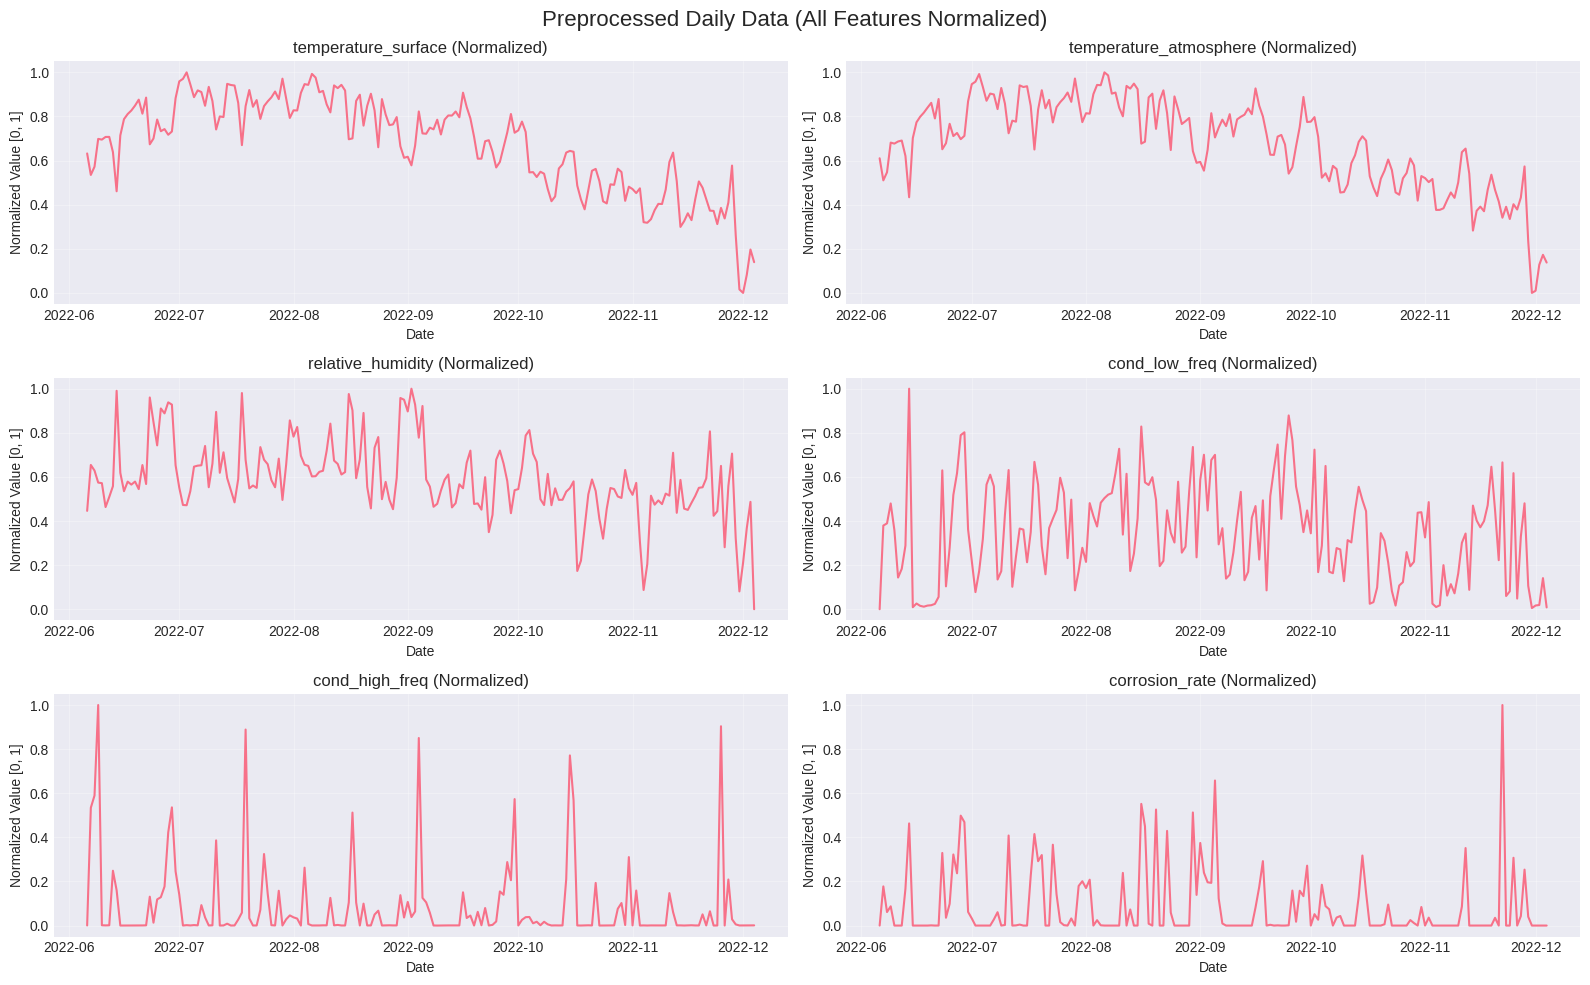

In [17]:
# Visualize normalized data
fig, axes = plt.subplots(3, 2, figsize=(16, 10))
fig.suptitle('Preprocessed Daily Data (All Features Normalized)', fontsize=16)

# Plot all features (all normalized to [0, 1])
for idx, col in enumerate(all_feature_cols):
    row = idx // 2
    col_idx = idx % 2
    
    axes[row, col_idx].plot(df_normalized['timestamp'], df_normalized[col], linewidth=1.5)
    axes[row, col_idx].set_title(f'{col} (Normalized)')
    axes[row, col_idx].set_ylabel('Normalized Value [0, 1]')
    axes[row, col_idx].set_ylim(-0.05, 1.05)
    
    axes[row, col_idx].set_xlabel('Date')
    axes[row, col_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Save Preprocessed Data

Save the preprocessed data for model training.

In [18]:
# Save to CSV file
output_csv = '../data/processed/preprocessed_daily_data.csv'
df_normalized.to_csv(output_csv, index=False)
print(f"Preprocessed data saved to: {output_csv}")

# Save scaler for future use (inverse transformation)
import joblib
scaler_path = '../models/minmax_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

Preprocessed data saved to: ../data/processed/preprocessed_daily_data.csv
Scaler saved to: ../models/minmax_scaler.pkl


In [19]:
# Optionally, save to a new database table
table_name = 'sensor_data_preprocessed'
df_normalized.to_sql(table_name, engine, if_exists='replace', index=False)
print(f"\nPreprocessed data saved to database table: {table_name}")


Preprocessed data saved to database table: sensor_data_preprocessed


## 6. Preprocessing Summary

In [20]:
print("=" * 70)
print("PREPROCESSING SUMMARY")
print("=" * 70)
print(f"\n1. OUTLIER REMOVAL (Z-score > 3):")
print(f"   - Original records: {len(df_raw)}")
print(f"   - Records after outlier removal: {len(df_no_outliers)}")
print(f"   - Outliers removed: {len(df_raw) - len(df_no_outliers)} ({((len(df_raw) - len(df_no_outliers)) / len(df_raw) * 100):.2f}%)")

print(f"\n2. DAILY AGGREGATION:")
print(f"   - Records after aggregation: {len(df_daily)}")
print(f"   - Time period: {df_daily['timestamp'].min().date()} to {df_daily['timestamp'].max().date()}")
print(f"   - Number of days: {len(df_daily)}")

print(f"\n3. NORMALIZATION (MinMaxScaler):")
print(f"   - ALL features normalized to [0, 1]: {len(all_feature_cols)} features")
print(f"     Features: {', '.join(all_feature_cols)}")
print(f"   - This includes both inputs AND target (required by sigmoid activation)")
print(f"   - Scaler saved for future inverse transformation")

print(f"\n4. OUTPUT:")
print(f"   - CSV file: {output_csv}")
print(f"   - Database table: {table_name}")
print(f"   - Scaler: {scaler_path}")
print(f"   - Final shape: {df_normalized.shape}")

print("\n" + "=" * 70)
print("Preprocessing complete! Data ready for model training.")
print("=" * 70)

PREPROCESSING SUMMARY

1. OUTLIER REMOVAL (Z-score > 3):
   - Original records: 8735
   - Records after outlier removal: 8447
   - Outliers removed: 288 (3.30%)

2. DAILY AGGREGATION:
   - Records after aggregation: 182
   - Time period: 2022-06-06 to 2022-12-04
   - Number of days: 182

3. NORMALIZATION (MinMaxScaler):
   - ALL features normalized to [0, 1]: 6 features
     Features: temperature_surface, temperature_atmosphere, relative_humidity, cond_low_freq, cond_high_freq, corrosion_rate
   - This includes both inputs AND target (required by sigmoid activation)
   - Scaler saved for future inverse transformation

4. OUTPUT:
   - CSV file: ../data/processed/preprocessed_daily_data.csv
   - Database table: sensor_data_preprocessed
   - Scaler: ../models/minmax_scaler.pkl
   - Final shape: (182, 7)

Preprocessing complete! Data ready for model training.
